In [22]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training

In [2]:
%load_ext autoreload

# Load Files

In [3]:
path = "SH_SC_1/"

In [3]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_SH_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [4]:
len(windmill)

12

In [5]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [6]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [7]:
df = features.parallelize_extract(df)

parallelize_extract time:  407.7401452064514


In [8]:
df,ply_models_rn,ws_rn = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,ws_wsr = features.extract_quantiles(df, "hws_uv_wsr")

In [10]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [11]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [136]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["GSRN", "TIME_CET"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET"]).reset_index(drop=True)

In [ ]:
len(df_train)

In [135]:
df_train.to_csv(constant.SH_SC_TRAIN_path, index=False)
df_evl.to_csv(constant.SH_SC_EVL_path, index=False)

# Neural Network Train

In [ ]:
df_train = pd.read_csv(constant.SH_SC_TRAIN_path)

In [13]:
target = ["VAERDI"]
n_groups=5
lr=0.001
num_epochs=20
hidden_size = 1000
output_size = 1

## Original Features


In [69]:
org_cols = ['Capacity_kw', 'Navhub_height', 'Rotor_diameter', 'wu10', 'wv10', 'wu100', 'wv100', 'tmp2', 'tmp100',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [15]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)
model_original, train_hist_original, test_hist_original = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs, save_name=path + "original_model.pth")

Epoch 0 train loss: 0.14259758591651917 test loss: 0.10396338254213333
Epoch 10 train loss: 0.06844126433134079 test loss: 0.07565051317214966
Epoch 19 train loss: 0.06392582505941391 test loss: 0.0531357005238533
Epoch 0 train loss: 0.05792052671313286 test loss: 0.05085761100053787
Epoch 10 train loss: 0.05364369601011276 test loss: 0.05115491524338722
Epoch 19 train loss: 0.051409412175416946 test loss: 0.05269671231508255
Epoch 0 train loss: 0.0515742190182209 test loss: 0.05136760696768761
Epoch 10 train loss: 0.047269001603126526 test loss: 0.04216431826353073
Epoch 19 train loss: 0.04545671120285988 test loss: 0.04388560354709625
Epoch 0 train loss: 0.04519395902752876 test loss: 0.04714588448405266
Epoch 10 train loss: 0.041972678154706955 test loss: 0.04682303965091705
Epoch 19 train loss: 0.04077162593603134 test loss: 0.04567394033074379


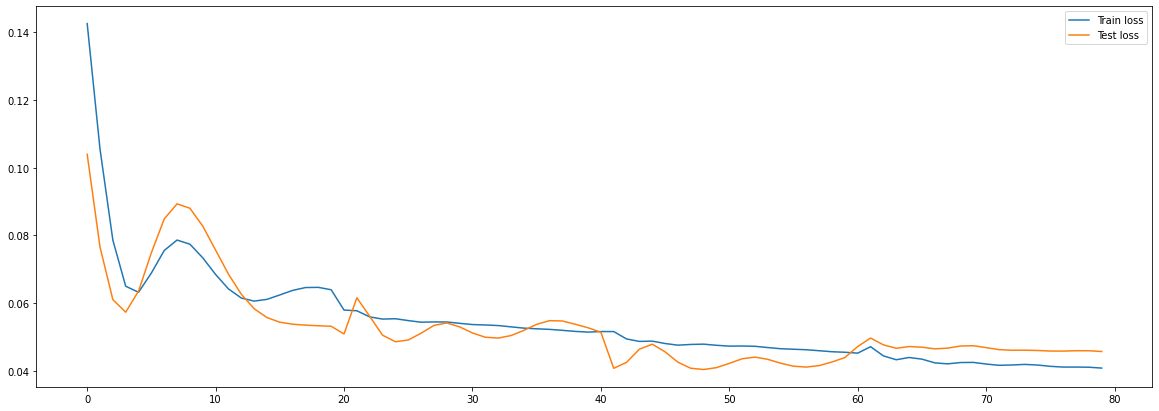

In [16]:
myplot.model_loss({"Train loss":train_hist_original, "Test loss": test_hist_original}, save_name=path+"original_loss.png")

## Windshear Features

In [74]:
wsr_cols = ['Capacity_kw','Navhub_height','Rotor_diameter','hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp',
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.5','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [24]:
model_wsr = MLP_Regression(
  input_size=48,
  hidden_size=hidden_size
)
model_wsr, train_hist_wsr, test_hist_wsr = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs, save_name=path+"wsr_model.pth")

Epoch 0 train loss: 0.15030726790428162 test loss: 0.11794933676719666
Epoch 10 train loss: 0.05603820085525513 test loss: 0.052599649876356125
Epoch 19 train loss: 0.04775063320994377 test loss: 0.0378999188542366
Epoch 0 train loss: 0.04149806872010231 test loss: 0.030035216361284256
Epoch 10 train loss: 0.0374603271484375 test loss: 0.028808506205677986
Epoch 19 train loss: 0.03582062944769859 test loss: 0.02876274473965168
Epoch 0 train loss: 0.0331287644803524 test loss: 0.0277054775506258
Epoch 10 train loss: 0.031795866787433624 test loss: 0.023524919524788857
Epoch 19 train loss: 0.03113379329442978 test loss: 0.02395508997142315
Epoch 0 train loss: 0.029300255700945854 test loss: 0.026192445307970047
Epoch 10 train loss: 0.027852391824126244 test loss: 0.02608983777463436
Epoch 19 train loss: 0.027214961126446724 test loss: 0.026523225009441376


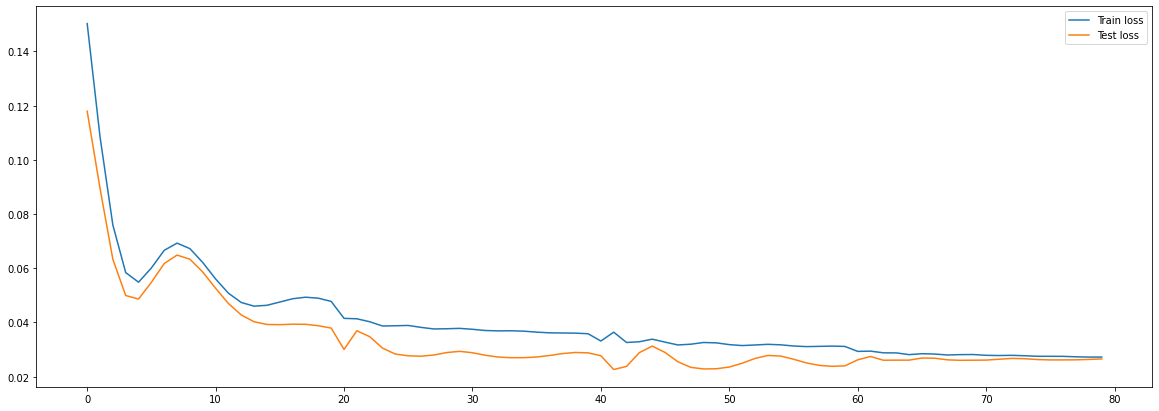

In [25]:
myplot.model_loss({"Train loss":train_hist_wsr, "Test loss": test_hist_wsr}, save_name=path+"wsr_loss.png")

## Geo Features

In [77]:
geo_cols = ['Capacity_kw', 'Navhub_height', 'Rotor_diameter',
'Slope', 'Aspect', 
'hws_u_rn','hws_v_rn','hws_uv_rn','hws_uv_rn^2','hws_uv_rn^3','htmp_exp', 
'hws_uv_rn_q0.1','hws_uv_rn_q0.5','hws_uv_rn_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [32]:
model_geo = MLP_Regression(
  input_size=50,
  hidden_size=hidden_size
)
model_geo, train_hist_geo, test_hist_geo = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs, save_name=path+"geo_model.pth")

Epoch 0 train loss: 0.15398599207401276 test loss: 0.11745483428239822
Epoch 10 train loss: 0.052899330854415894 test loss: 0.04647305607795715
Epoch 19 train loss: 0.04172084853053093 test loss: 0.03066116012632847
Epoch 0 train loss: 0.03473621979355812 test loss: 0.02381344512104988
Epoch 10 train loss: 0.029688771814107895 test loss: 0.022298840805888176
Epoch 19 train loss: 0.028319237753748894 test loss: 0.02222374640405178
Epoch 0 train loss: 0.026044828817248344 test loss: 0.02342928573489189
Epoch 10 train loss: 0.025097275152802467 test loss: 0.019872726872563362
Epoch 19 train loss: 0.02466038428246975 test loss: 0.020415792241692543
Epoch 0 train loss: 0.02357182838022709 test loss: 0.01765640638768673
Epoch 10 train loss: 0.022041654214262962 test loss: 0.016933469101786613
Epoch 19 train loss: 0.021559718996286392 test loss: 0.01665126532316208


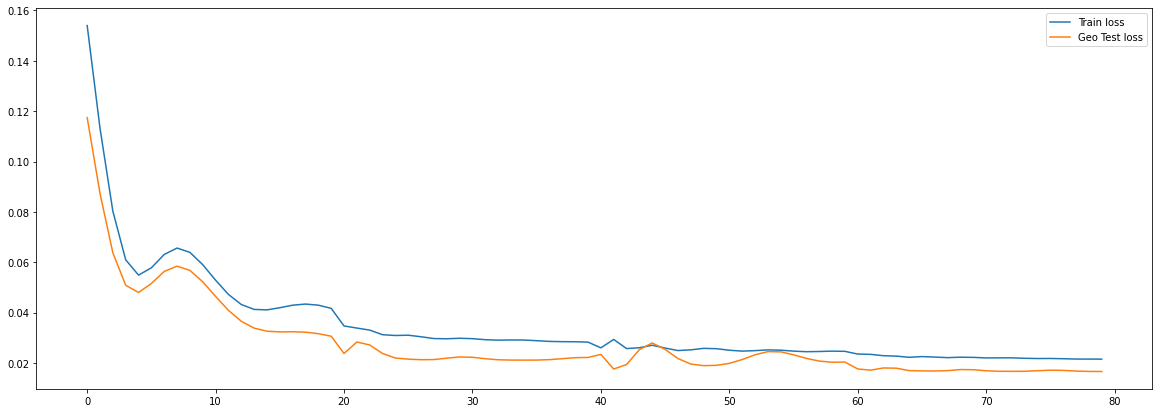

In [33]:
myplot.model_loss({"Train loss":train_hist_geo, "Geo Test loss": test_hist_geo}, save_name=path+"geo_loss.png")

## Semigeo Features

In [80]:
semigeo_cols = ['Capacity_kw','Navhub_height', 'Rotor_diameter',
'Slope', 'Aspect', 'Roughness',
'hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp', 
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.5','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [38]:
model_semigeo = MLP_Regression(
  input_size=51,
  hidden_size=1000
)
model_semigeo, train_hist_semigeo, test_hist_semigeo = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs, save_name=path+"semigeo_model.pth")

Epoch 0 train loss: 0.15728417038917542 test loss: 0.12015014886856079
Epoch 10 train loss: 0.0611196905374527 test loss: 0.05761757120490074
Epoch 19 train loss: 0.049332305788993835 test loss: 0.03791813924908638
Epoch 0 train loss: 0.0428098700940609 test loss: 0.030338771641254425
Epoch 10 train loss: 0.03714641556143761 test loss: 0.025586802512407303
Epoch 19 train loss: 0.035188037902116776 test loss: 0.024669473990797997
Epoch 0 train loss: 0.03166067972779274 test loss: 0.028833115473389626
Epoch 10 train loss: 0.03117648884654045 test loss: 0.02410583570599556
Epoch 19 train loss: 0.030535385012626648 test loss: 0.02481452003121376
Epoch 0 train loss: 0.029082147404551506 test loss: 0.024408945813775063
Epoch 10 train loss: 0.027339432388544083 test loss: 0.02404121495783329
Epoch 19 train loss: 0.026770181953907013 test loss: 0.02438407391309738


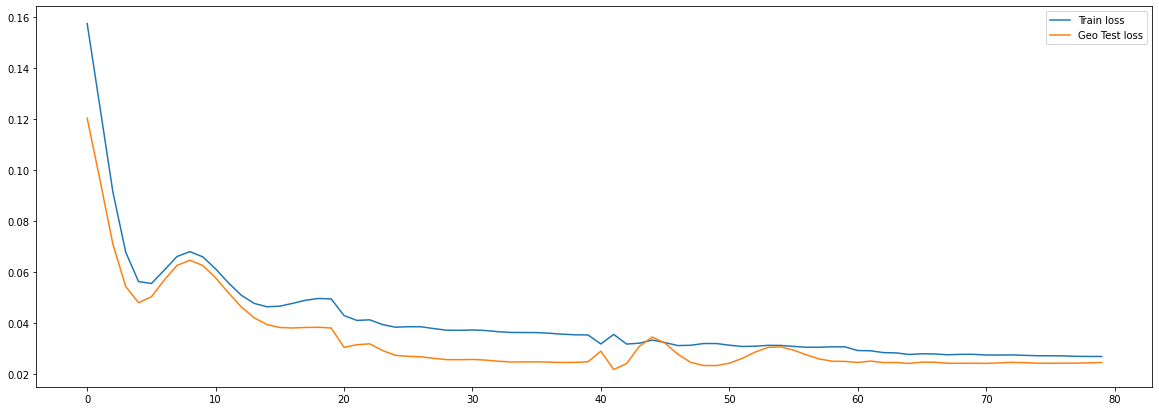

In [39]:
myplot.model_loss({"Train loss":train_hist_semigeo, "Geo Test loss": test_hist_semigeo}, save_name=path+"semigeo_loss.png")